# Tutorial on PnP-LADMM

#### Imports

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imsave

import torch
#from torchmetrics.image import TotalVariation
#from torchmetrics.functional.image import image_gradients
from drunet.network_unet import UNetRes as net
from torchvision.transforms import GaussianBlur

#### Data-loading

In [2]:
x_real = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))

In [5]:
def T(x):
    x_out = x.clone()
    x_out = x_out.unsqueeze(2)
    white_noise = np.random.normal(loc = 0, scale = 0.4, size = (x_out.shape[0], x_out.shape[1]))
    x_out[:, :, 0] = x_out[:, :, 0] + white_noise

    return x_out

In [6]:
y = T(x_real)
print(y.shape)

torch.Size([600, 800, 1])


Text(0.5, 1.0, 'Imagen con ruido gaussiano aditivo')

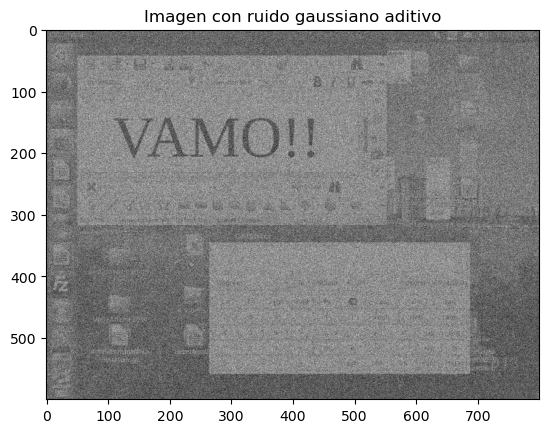

In [7]:
plt.imshow(y[:,:,0], cmap = 'gray')
plt.title('Imagen con ruido gaussiano aditivo')

In [16]:
model_path = os.path.join('./drunet/drunet_gray.pth')
model = net(in_nc=1+1, out_nc=1, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
for _, v in model.named_parameters():
            v.requires_grad = False

In [9]:
def get_sigma(iter_num=15, modelSigma1=49.0, modelSigma2=2.55, w=1.0):
    '''
    One can change the sigma to implicitly change the trade-off parameter
    between fidelity term and prior term
    '''
    modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
    modelSigmaS_lin = np.linspace(modelSigma1, modelSigma2, iter_num).astype(np.float32)
    sigmas = (modelSigmaS*w+modelSigmaS_lin*(1-w))/255.
    return sigmas

In [10]:
noise_level_model =  7.65/255.0
iter_num = 8
modelSigma1 = 49
modelSigma2 = noise_level_model * 255.0
sigma = get_sigma(iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1.0)
sigmas = torch.tensor(sigma)

In [11]:
# convert uint (HxWxn_channels) to 4-dimensional torch tensor
def uint2tensor4(img):
    if img.ndim == 2:
        #agrega una dimension mas al array (600,800) --> (600,800,1)
        img = np.expand_dims(img, axis=2)
        #np.ascontiguousarray(img) guarda todas las entradas de la red en lugares adyacentes en memoria
        #permute cambia las dims (600, 800, 1) --> (1, 600, 800)
        #float() pasa las entradas del array a tipo float
        #div(255.) divide todos los elementos entre 255
        #unsqueeze agrega una dimension en la dim especificada (1, 600, 800) --> (1, 1, 600, 800)
    return torch.from_numpy(np.ascontiguousarray(img)).permute(2, 0, 1).float().div(255.).unsqueeze(0)

In [93]:
salida = uint2tensor4(x_real)
print(salida.shape)

torch.Size([1, 1, 600, 800])


In [94]:
print(y.shape)
y_4 = uint2tensor4(y)
print(y_4.shape)
y_in = torch.cat((y_4, sigmas[0].float().repeat(1, 1, y_4.shape[2], y_4.shape[3])), dim=1)
print(y_in.shape)

torch.Size([600, 800, 1])
torch.Size([1, 1, 600, 800])
torch.Size([1, 2, 600, 800])


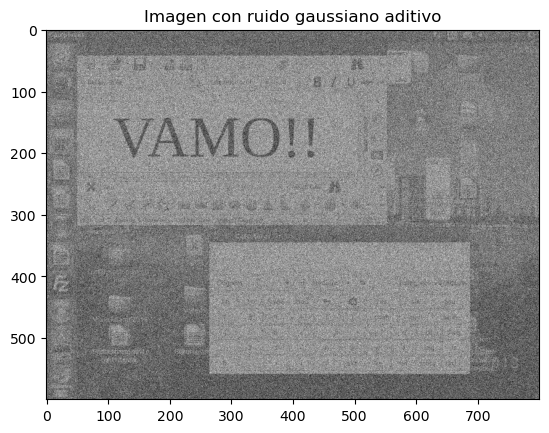

torch.Size([1, 2, 600, 800])
torch.Size([1, 1, 600, 800])


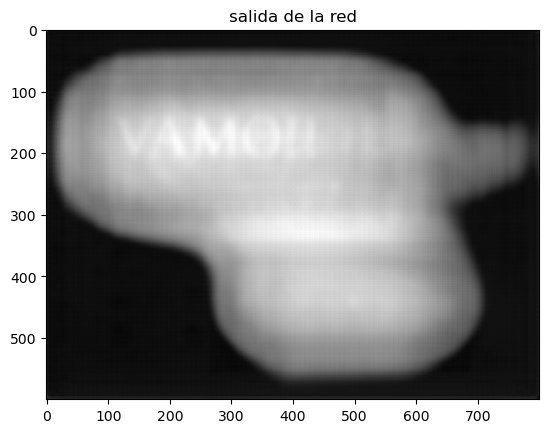

In [13]:
x_real = torch.tensor(imread(os.path.join("./imagenes", "VAMO.png"), as_gray=True))
y = T(x_real)

plt.imshow(y[:,:,0], cmap = 'gray')
plt.title('Imagen con ruido gaussiano aditivo')
plt.show()

y_4 = uint2tensor4(y)
y_in = torch.cat((y_4, sigmas[0].float().repeat(1, 1, y_4.shape[2], y_4.shape[3])), dim=1)
print(y_in.shape)
y_out = model(y_in)
print(y_out.shape)

plt.imshow(y_out[0,0,:,:],cmap = 'gray')
plt.title('salida de la red')
plt.show()

In [95]:
print(y.shape)
y_4 = uint2tensor4(y)
for i in range(iter_num):
    y_in = torch.cat((y_4, sigmas[i].float().repeat(1, 1, y_4.shape[2], y_4.shape[3])), dim=1)
    y_out = model(y_in)
    y_4 = y_out

torch.Size([600, 800, 1])


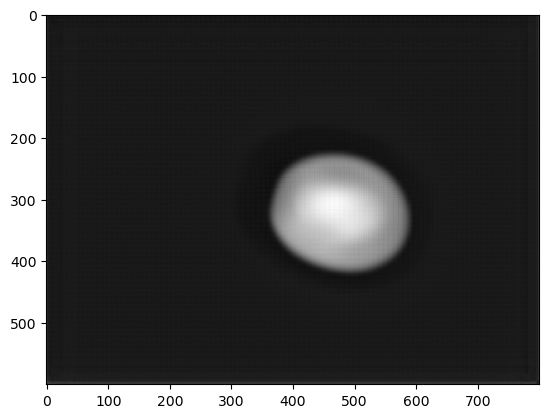

In [97]:
plt.imshow(y_out[0,0,:,:],cmap = 'gray')

In [45]:
for i in range(iter_num):
    print(i)
    
    y = uint2tensor4(y)

    y = torch.cat((y, sigmas[i].float().repeat(1, 1, y.shape[2], y.shape[3])), dim=1)
    y_out = model(y)

0


RuntimeError: Given groups=1, weight of size [64, 2, 3, 3], expected input[1, 801, 1, 600] to have 2 channels, but got 801 channels instead